# Component

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/gdsfactory/binder-sandbox/HEAD) or [Colab](https://colab.research.google.com/github/gdsfactory/gdsfactory/blob/master/docs/notebooks/00_geometry.ipynb).

A `Component` is like an empty canvas, where you can add polygons, references to other Components and ports (to connect to other components)

![](https://i.imgur.com/D4qaJpi.png)

In gdsfactory **all dimensions** are in **microns**

Lets add a polygon

2022-11-27 23:43:38.432 | INFO     | gdsfactory.config:<module>:46 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.2.6


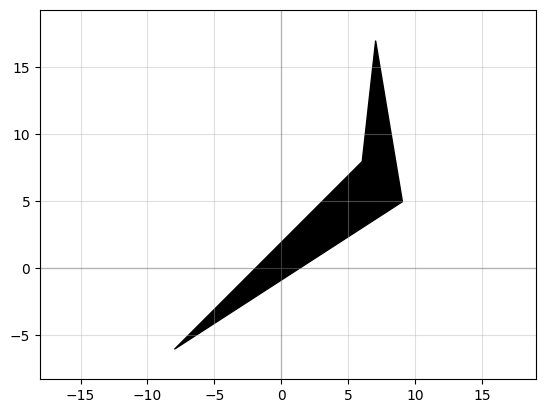

myComponent: uid 69ff498f, ports [], references [], 1 polygons

In [1]:
import gdsfactory as gf

# Create a blank component (essentially an empty GDS cell with some special features)
c = gf.Component("myComponent")

# Create and add a polygon from separate lists of x points and y points
# (Can also be added like [(x1,y1), (x2,y2), (x3,y3), ... ]
poly1 = c.add_polygon(
    [(-8, 6, 7, 9), (-6, 8, 17, 5)], layer=1
)  # GDS layers are tuples of ints (but if we use only one number it assumes the other number is 0)

c  # show it in matplotlib and klayout (you need to have klayout open and install gdsfactory from the git repo with make install)

**Exercise** :

Make a component similar to the one above that has a second polygon in layer (1, 1)

myComponent2: uid 027cff57, ports [], references ['text_1', 'text_2', 'rectangle_1'], 0 polygons


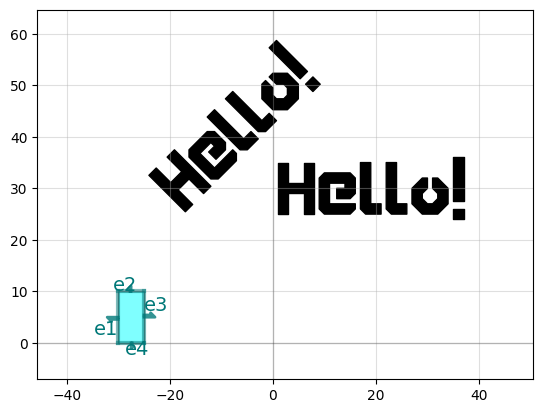

myComponent2: uid 027cff57, ports [], references ['text_1', 'text_2', 'rectangle_1'], 0 polygons

In [2]:
c = gf.Component("myComponent2")
# Create some new geometry from the functions available in the geometry library
t = gf.components.text("Hello!")
r = gf.components.rectangle(size=[5, 10], layer=(2, 0))

# Add references to the new geometry to c, our blank component
text1 = c.add_ref(t)  # Add the text we created as a reference
# Using the << operator (identical to add_ref()), add the same geometry a second time
text2 = c << t
r = c << r  # Add the rectangle we created

# Now that the geometry has been added to "c", we can move everything around:
text1.movey(25)
text2.move([5, 30])
text2.rotate(45)
r.movex(-15)
r.movex(-15)

print(c)
c

## Connect **ports**

Any Component can have "Port"s in it which allow you to snap geometry together
like legos.

Below is an example where we write a simple function to make a
rectangular straight, assign ports to the ends of the rectangle, and then snap
those rectangles together

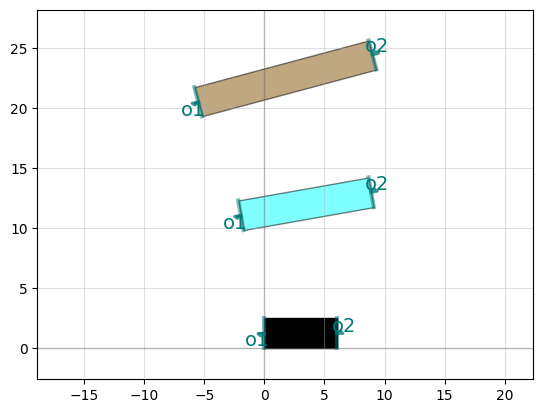

straights_not_connected: uid a392a92c, ports [], references ['straight_1', 'straight_2', 'straight_3'], 0 polygons

In [3]:
@gf.cell
def straight(length=10, width=1, layer=(1, 0)):
    WG = gf.Component()
    WG.add_polygon([(0, 0), (length, 0), (length, width), (0, width)], layer=layer)
    WG.add_port(
        name="o1", center=[0, width / 2], width=width, orientation=180, layer=layer
    )
    WG.add_port(
        name="o2", center=[length, width / 2], width=width, orientation=0, layer=layer
    )
    return WG


c = gf.Component("straights_not_connected")

wg1 = c << straight(length=6, width=2.5, layer=1)
wg2 = c << straight(length=11, width=2.5, layer=2)
wg3 = c << straight(length=15, width=2.5, layer=3)
wg2.movey(10).rotate(10)
wg3.movey(20).rotate(15)

c

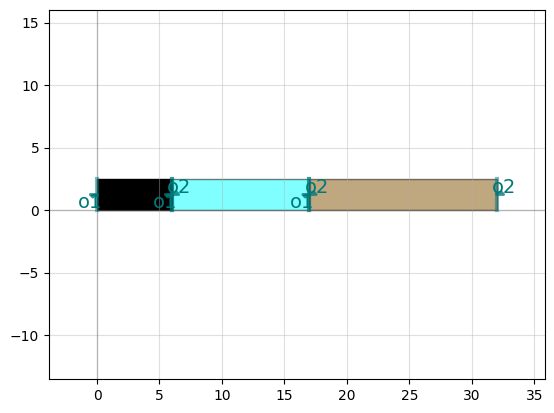

straights_not_connected: uid a392a92c, ports [], references ['straight_1', 'straight_2', 'straight_3'], 0 polygons

In [4]:
# Now we can connect everything together using the ports:

# Each straight has two ports: 'W0' and 'E0'.  These are arbitrary
# names defined in our straight() function above

# Let's keep wg1 in place on the bottom, and connect the other straights to it.
# To do that, on wg2 we'll grab the "W0" port and connect it to the "E0" on wg1:
wg2.connect("o1", wg1.ports["o2"])
# Next, on wg3 let's grab the "W0" port and connect it to the "E0" on wg2:
wg3.connect("o1", wg2.ports["o2"])

c

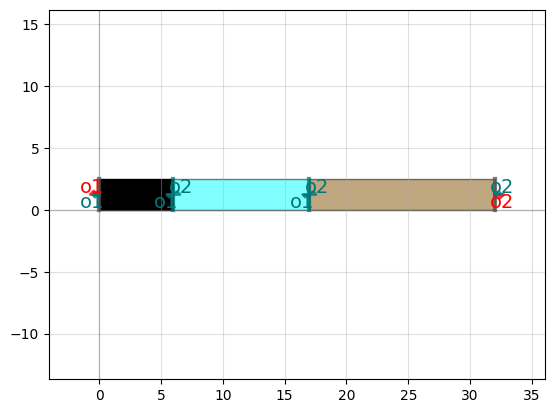

straights_not_connected: uid a392a92c, ports ['o1', 'o2'], references ['straight_1', 'straight_2', 'straight_3'], 0 polygons

In [5]:
c.add_port("o1", port=wg1.ports["o1"])
c.add_port("o2", port=wg3.ports["o2"])
c

As you can see the `red` labels are for the component ports while
`blue` labels are for the sub-ports (children ports)

## Move and rotate references

There are several actions we can take to move and rotate the geometry.

These actions include movement, rotation, and reflection.

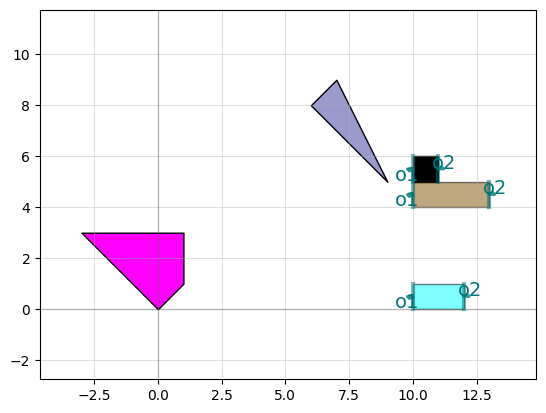

straights_connected: uid ccdafe83, ports [], references ['straight_1', 'straight_2', 'straight_3'], 2 polygons

In [6]:
c = gf.Component("straights_connected")

wg1 = c << straight(length=1, layer=(1, 0))
wg2 = c << straight(length=2, layer=(2, 0))
wg3 = c << straight(length=3, layer=(3, 0))

# Create and add a polygon from separate lists of x points and y points
# e.g. [(x1, x2, x3, ...), (y1, y2, y3, ...)]
poly1 = c.add_polygon([(8, 6, 7, 9), (6, 8, 9, 5)], layer=(4, 0))

# Alternatively, create and add a polygon from a list of points
# e.g. [(x1,y1), (x2,y2), (x3,y3), ...] using the same function
poly2 = c.add_polygon([(0, 0), (1, 1), (1, 3), (-3, 3)], layer=(5, 0))

# Shift the first straight we created over by dx = 10, dy = 5
wg1.move([10, 5])

# Shift the second straight over by dx = 10, dy = 0
wg2.move(origin=[0, 0], destination=[10, 0])

# Shift the third straight over by dx = 0, dy = 4
wg3.move([1, 1], [5, 5], axis="y")

# Move "from" x=0 "to" x=10 (dx=10)
wg3.movex(0, 10)

c

## Ports

Although our straights wg1/wg2/wg3 have ports, they're only references
of the component ``c`` we're working in, and ``c`` itself does not -- it only draws
the subports (ports of wg1, wg2, wg3) as a convenience.  We need to add ports
that we specifically want in our new component ``c``. add_port() can take a
port argument which allows you to pass it an underlying reference port to
copy. You can also rename the port if you desire:

You can access the ports of a Component or ComponentReference

In [7]:
wg2.ports

{'o1': Port (name o1, center [10.   0.5], width 1, orientation 180.0, layer (2, 0), port_type optical),
 'o2': Port (name o2, center [12.   0.5], width 1, orientation 0.0, layer (2, 0), port_type optical)}

## References

Now that we have our component ``c`` which is a multi-straight component, we
can add references to that component in a new blank canvas we'll call ``c2``.
We'll add two copies of ``c`` to c2, and shift one so we can see them both

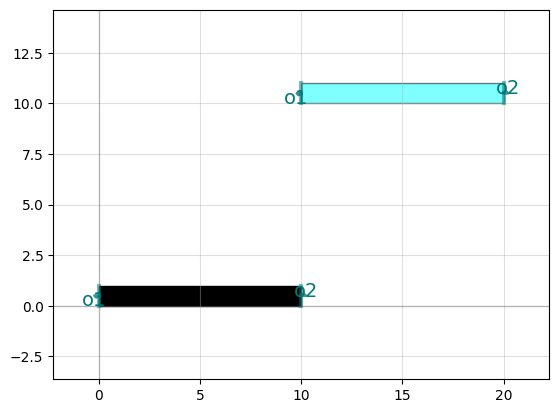

MultiMultiWaveguide: uid 7f5f13ac, ports [], references ['straight_1', 'straight_2'], 0 polygons

In [8]:
c2 = gf.Component("MultiMultiWaveguide")
wg1 = straight()
wg2 = straight(layer=(2, 0))
mwg1_ref = c2.add_ref(wg1)
mwg2_ref = c2.add_ref(wg2)
mwg2_ref.move(destination=[10, 10])
c2

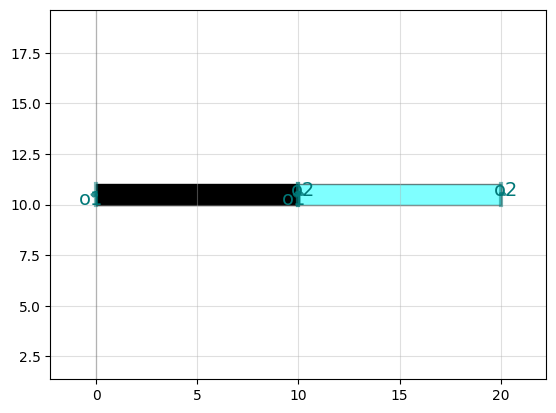

MultiMultiWaveguide: uid 7f5f13ac, ports [], references ['straight_1', 'straight_2'], 0 polygons

In [9]:
# Like before, let's connect mwg1 and mwg2 together
mwg1_ref.connect(port="o2", destination=mwg2_ref.ports["o1"])
c2

## Labels

We can also label (annotate) our devices, in order to record information
directly into the final GDS file without putting any extra geometry onto any
layer
This label will display in a GDS viewer, but will not be rendered or printed
like the polygons created by gf.components.text().
You can use for example gf.show() to see the labels in Klayout

2022-11-27 23:43:40.532 | INFO     | gdsfactory.component:_write_library:1454 - Wrote to 'MultiMultiWaveguideWithLabels.gds'


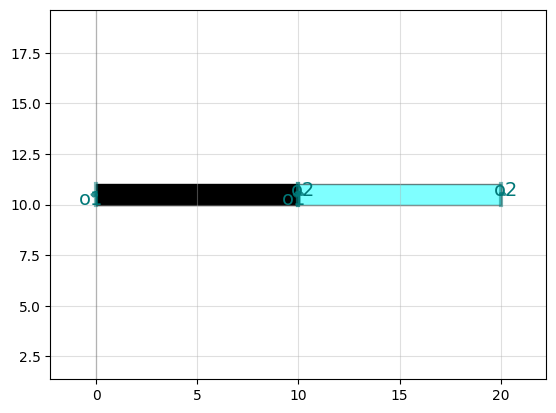

MultiMultiWaveguide: uid 7f5f13ac, ports [], references ['straight_1', 'straight_2'], 0 polygons

In [10]:
c2.add_label(text="First label", position=mwg1_ref.center)
c2.add_label(text="Second label", position=mwg2_ref.center)

# It's very useful for recording information about the devices or layout
c2.add_label(
    text=f"The x size of this\nlayout is {c2.xsize}",
    position=(c2.xmax, c2.ymax),
    layer=(10, 0),
)

# Again, note we have to write the GDS for it to be visible (view in KLayout)
c2.write_gds("MultiMultiWaveguideWithLabels.gds")
c2

## Boolean shapes

If you want to subtract one shape from another, merge two shapes, or
perform an XOR on them, you can do that with the `boolean()` function.


The ``operation`` argument should be {not, and, or, xor, 'A-B', 'B-A', 'A+B'}.
Note that 'A+B' is equivalent to 'or', 'A-B' is equivalent to 'not', and
'B-A' is equivalent to 'not' with the operands switched


/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1438: UserWarning: Component 'Unnamed_c2f05752' contains 1 Unnamed cells
  warnings.warn(


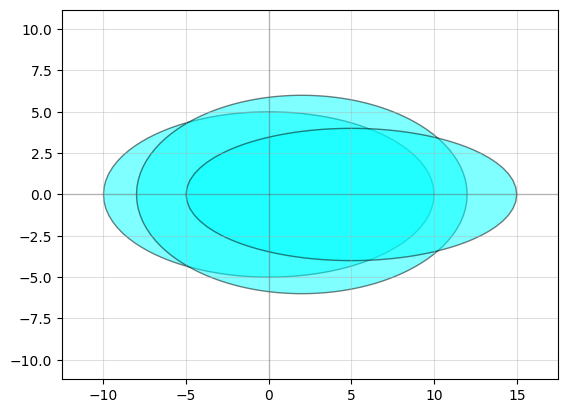

Unnamed_c2f05752: uid c2f05752, ports [], references ['ellipse_1', 'ellipse_2', 'ellipse_3'], 0 polygons

In [11]:
import gdsfactory as gf

c = gf.Component()
e1 = c.add_ref(gf.components.ellipse(layer=(2, 0)))
e2 = c.add_ref(gf.components.ellipse(radii=(10, 6), layer=(2, 0))).movex(2)
e3 = c.add_ref(gf.components.ellipse(radii=(10, 4), layer=(2, 0))).movex(5)
c

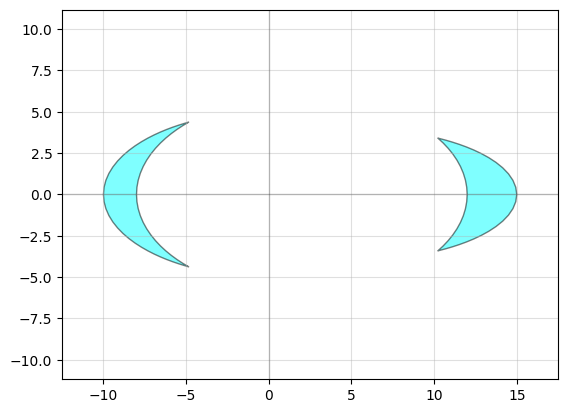

boolean_c5ebe741: uid c7e69bd5, ports [], references [], 2 polygons

In [12]:
c2 = gf.geometry.boolean(A=[e1, e3], B=e2, operation="A-B", layer=(2, 0))
c2

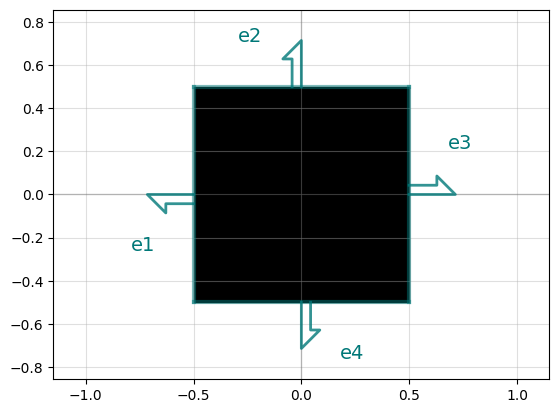

rectangle_with_label: uid 1df69aba, ports [], references ['rectangle_1'], 0 polygons

In [13]:
import gdsfactory as gf

c = gf.Component("rectangle_with_label")
r = c << gf.components.rectangle(size=(1, 1))
r.x = 0
r.y = 0
c.add_label(
    text="Demo label",
    position=(0, 0),
    layer=(1, 0),
)
c

## Move Reference by port

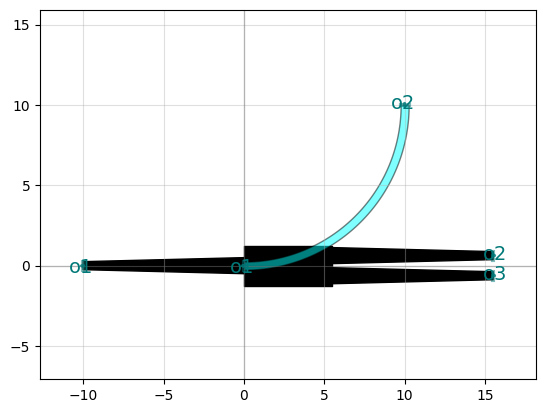

ref_port_sample: uid 42dba7a5, ports [], references ['mmi1x2_1', 'bend_circular_1'], 0 polygons

In [14]:
c = gf.Component("ref_port_sample")
mmi = c.add_ref(gf.components.mmi1x2())
bend = c.add_ref(gf.components.bend_circular(layer=(2, 0)))
c

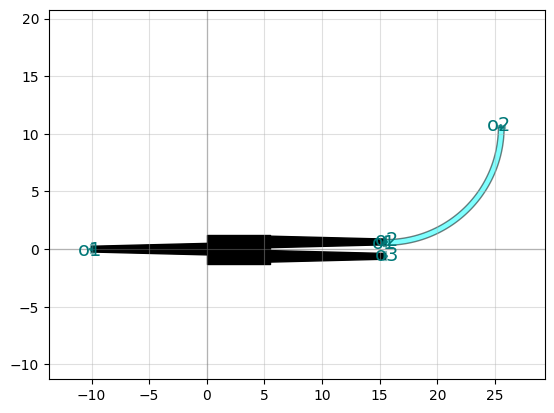

ref_port_sample: uid 42dba7a5, ports [], references ['mmi1x2_1', 'bend_circular_1'], 0 polygons

In [15]:
bend.connect("o1", mmi.ports["o2"])  # connects follow Source, destination syntax
c

## Mirror reference

By default the mirror works along the x=0 axis.

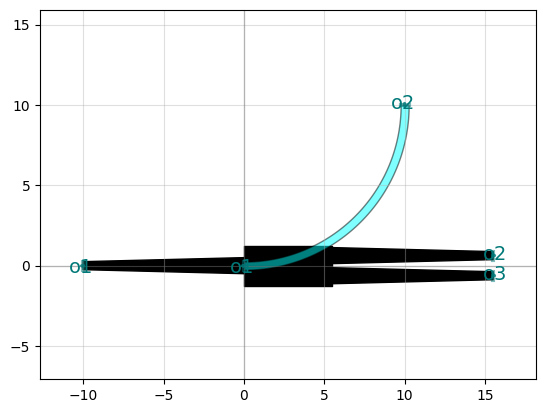

ref_mirror: uid 1b61d1bc, ports [], references ['mmi1x2_1', 'bend_circular_1'], 0 polygons

In [16]:
c = gf.Component("ref_mirror")
mmi = c.add_ref(gf.components.mmi1x2())
bend = c.add_ref(gf.components.bend_circular(layer=(2, 0)))
c

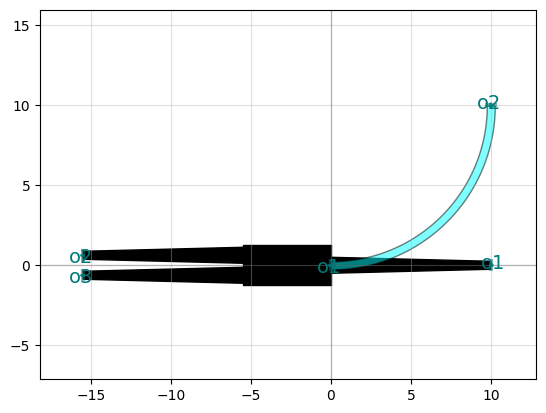

ref_mirror: uid 1b61d1bc, ports [], references ['mmi1x2_1', 'bend_circular_1'], 0 polygons

In [17]:
mmi.mirror()
c

## Write GDS

[GDSII](https://en.wikipedia.org/wiki/GDSII) is the Standard format for exchanging CMOS and Photonic circuits.

You can write your Component to GDS file.

In [18]:
c.write_gds("demo.gds")

2022-11-27 23:43:41.681 | INFO     | gdsfactory.component:_write_library:1454 - Wrote to 'demo.gds'


PosixPath('demo.gds')

You can see the GDS file in Klayout viewer.

Sometimes you also want to save the GDS together with metadata (settings, port names, widths, locations ...) in YAML

In [19]:
c.write_gds_with_metadata("demo.gds")

2022-11-27 23:43:41.689 | INFO     | gdsfactory.component:_write_library:1454 - Wrote to 'demo.gds'


2022-11-27 23:43:41.698 | INFO     | gdsfactory.component:write_gds_with_metadata:1539 - Write YAML metadata to 'demo.yml'


PosixPath('demo.gds')

[based on phidl
tutorial](https://github.com/amccaugh/phidl/blob/master/phidl/phidl_tutorial_example.py#L35)